In [0]:
# from google.colab import files
# uploaded = files.upload()

In [55]:
from pandas import read_csv
from datetime import datetime

def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')

dataset = read_csv('./data/beijing.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)

dataset.drop('No', axis=1, inplace=True)
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
dataset['pollution'].fillna(0, inplace=True)
dataset = dataset[24:]
print(dataset.head(5))

dataset.to_csv('./data/pollution.csv')

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


In [0]:
# from pandas import read_csv
# from matplotlib import pyplot

# dataset = read_csv('pollution.csv', header=0, index_col=0)
# values = dataset.values
# # specify columns to plot
# groups = [0, 1, 2, 3, 5, 6, 7]
# i = 1
# # plot each column
# pyplot.figure()
# for group in groups:
# 	pyplot.subplot(len(groups), 1, i)
# 	pyplot.plot(values[:, group])
# 	pyplot.title(dataset.columns[group], y=0.5, loc='right')
# 	i += 1
# pyplot.show()

In [0]:
# from pandas import DataFrame
import pandas

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pandas.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [58]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values

encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])

values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

reframed = series_to_supervised(scaled, 1, 1)

reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  ...  var7(t-1)  var8(t-1)   var1(t)
1   0.129779   0.352941   0.245902  ...   0.000000        0.0  0.148893
2   0.148893   0.367647   0.245902  ...   0.000000        0.0  0.159960
3   0.159960   0.426471   0.229508  ...   0.000000        0.0  0.182093
4   0.182093   0.485294   0.229508  ...   0.037037        0.0  0.138833
5   0.138833   0.485294   0.229508  ...   0.074074        0.0  0.109658

[5 rows x 9 columns]


In [59]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24 * 4
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

print(train.shape)
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(35040, 9)
(35040, 1, 8) (35040,) (8759, 1, 8) (8759,)


In [60]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# Network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 35040 samples, validate on 8759 samples
Epoch 1/50
 - 3s - loss: 0.0345 - val_loss: 0.0343
Epoch 2/50
 - 1s - loss: 0.0143 - val_loss: 0.0143
Epoch 3/50
 - 1s - loss: 0.0140 - val_loss: 0.0134
Epoch 4/50
 - 1s - loss: 0.0140 - val_loss: 0.0131
Epoch 5/50
 - 1s - loss: 0.0139 - val_loss: 0.0132
Epoch 6/50
 - 1s - loss: 0.0139 - val_loss: 0.0132
Epoch 7/50
 - 1s - loss: 0.0139 - val_loss: 0.0136
Epoch 8/50
 - 1s - loss: 0.0139 - val_loss: 0.0138
Epoch 9/50
 - 1s - loss: 0.0139 - val_loss: 0.0137
Epoch 10/50
 - 1s - loss: 0.0139 - val_loss: 0.0137
Epoch 11/50
 - 1s - loss: 0.0139 - val_loss: 0.0137
Epoch 12/50
 - 1s - loss: 0.0139 - val_loss: 0.0137
Epoch 13/50
 - 1s - loss: 0.0138 - val_loss: 0.0138
Epoch 14/50
 - 1s - loss: 0.0138 - val_loss: 0.0136
Epoch 15/50
 - 1s - loss: 0.0138 - val_loss: 0.0138
Epoch 16/50
 - 1s - loss: 0.0138 - val_loss: 0.0140
Epoch 17/50
 - 1s - loss: 0.0138 - val_loss: 0.0138
Epoch 18/50
 - 1s - loss: 0.0138 - val_loss: 0.0139
Epoch 19/50
 - 1s - loss

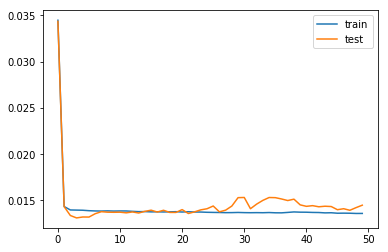

In [61]:
# plot history
from matplotlib import pyplot

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [62]:
from math import sqrt
from numpy import concatenate
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

# make a prediction
print(test_X.shape)
# test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

(8759, 1, 8)
Test RMSE: 25.943
